In [173]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
#Holt Winter Model

import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')
plt.style.use('fivethirtyeight')

def mean_absolute_percentage_error(y_true, y_pred):
  y_true,y_pred= np.array(y_true), np.array(y_pred)
  return np.mean(np.abs((y_true - y_pred)/y_true)) *100  

In [174]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [175]:
data= pd.read_csv("cleaned_data_csv.csv")

In [176]:
def create_df(data,location):
    #Selecting the 7 key columns for country in dataset
    data=data[data['Location']==location].copy()
    data=data[['Date','Total_Cases','New_Cases',
         'Total_deaths','New_deaths',
         "people vaccinated per hundred", 'people_fully_vaccinated_per_hundred',
          'new cases per million']].copy()
    #Convert to datetime
    #data2.date = pd.to_datetime(data2['Date'])
    data['Date'] = pd.DatetimeIndex(data['Date'])
    return data

In [177]:
asia_1=create_df(data,'Japan')

In [178]:
asia_1=asia_1.loc[:,['Date',"new cases per million"]]
asia_1=asia_1.set_index('Date')

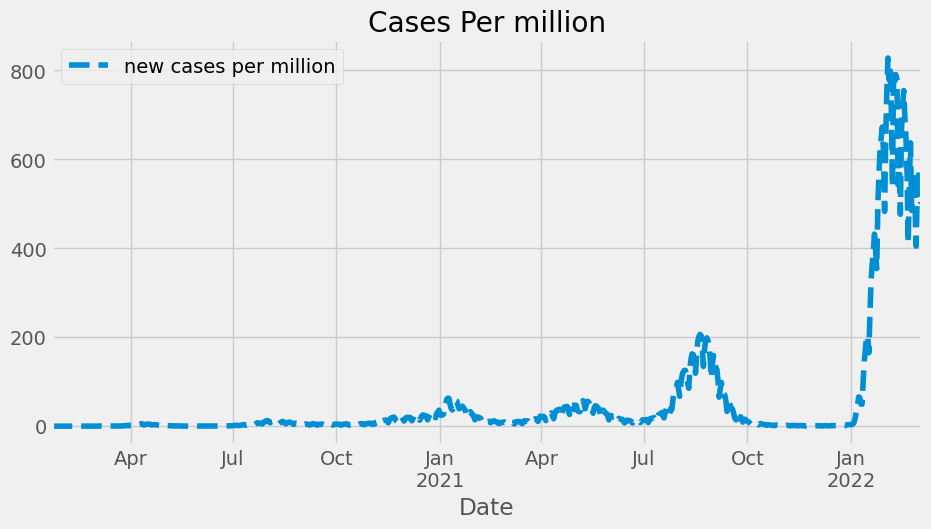

In [179]:
color_pal = sns.color_palette()
asia_1.plot(style='--',
               figsize=(10,5),
               ms=1,
               color=color_pal[0],
               title='Cases Per million')
plt.show()

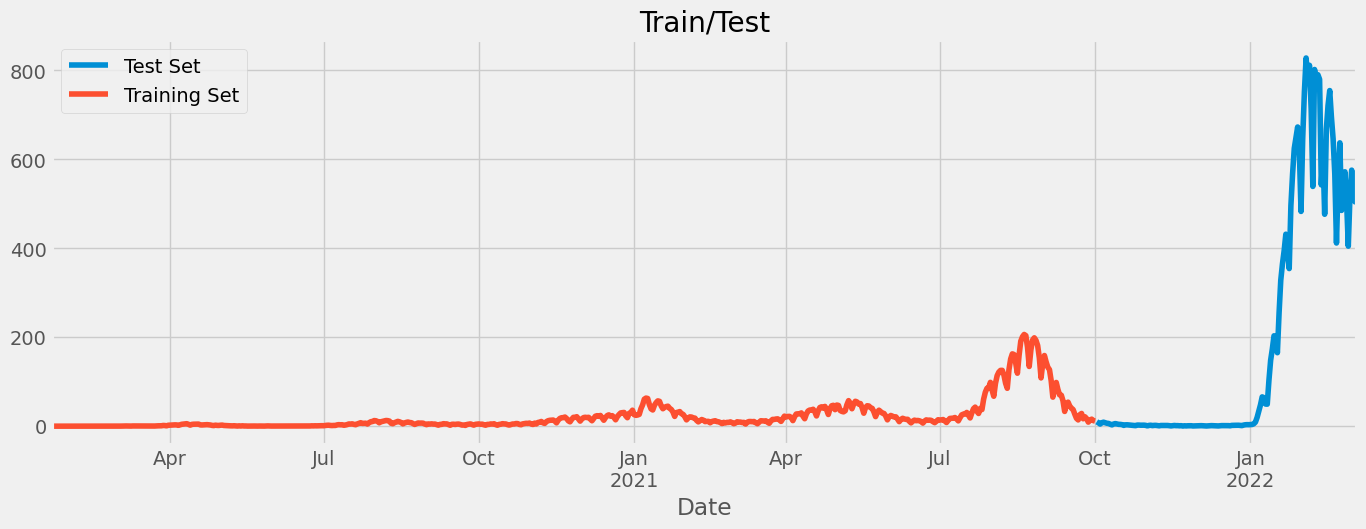

In [180]:
split_date='01-oct-2021'

asia_train1 = asia_1.loc[asia_1.index <=split_date].copy()
asia_test1 = asia_1.loc[asia_1.index >split_date].copy()

asia_test1 \
          .rename(columns={"new cases per million": 'Test Set'}) \
          .join(asia_train1.rename(columns={"new cases per million": 'Training Set'}),
                how='outer') \
          .plot(figsize=(15,5), title='Train/Test')
plt.show()

In [181]:
# fit an ARIMA model and plot residual errors
from pandas import datetime
from pandas import read_csv
from pandas import DataFrame
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima

from matplotlib import pyplot
# load dataset
auto_arima_model=auto_arima(asia_train1,trace=True,Supress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4051.326, Time=0.74 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4162.834, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4140.167, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4106.722, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4160.838, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4056.754, Time=0.34 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4056.358, Time=0.48 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=4031.287, Time=0.90 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=4044.028, Time=1.18 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=3856.254, Time=1.22 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=4021.216, Time=0.64 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=3818.945, Time=4.20 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=3981.572, Time=1.07 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=3847.199, Time=2.33 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept

In [182]:
# Define function to evaluate model performance
def evaluate_model(predictions_asia1, actual_asia1):
    mse_asia1 = mean_squared_error(actual_asia1, predictions_asia1)
    rmse_asia1 = np.sqrt(mse_asia1)
    mape_asia1 = np.mean(np.abs((actual_asia1 - predictions_asia1) / actual_asia1)) * 100
    return mse_asia1, rmse_asia1, mape_asia1

In [183]:
# Define ARIMA model parameters
p_asia1 = 2
d_asia1 = 1
q_asia1 = 2

In [184]:
# Fit the ARIMA model on train data
model_asia1 = ARIMA(asia_train1, order=(p_asia1, d_asia1, q_asia1))
results = model_asia1.fit()

In [185]:
n_days_asia1 = 365

In [186]:
# Use the trained model to make predictions for the next n_days
forecast_asia1 = results.forecast(steps=n_days_asia1)

In [187]:
# Create a date range for the forecasted dates
forecast_dates_asia1 = pd.date_range(start=asia_1.index[-1], periods=n_days_asia1+1)[1:]

In [188]:
# Convert the forecasted values to a pandas DataFrame
forecast_df_asia1 = pd.DataFrame({'Cases': forecast_asia1}, index=forecast_dates_asia1)

In [189]:
test_predictions_asia1 = results.predict(start=asia_test1.index[0], end=asia_test1.index[-1], dynamic=False)

In [190]:
mse_asia1, rmse_asia1, mape_asia1 = evaluate_model(test_predictions_asia1, asia_test1)

In [191]:

# Print model performance metrics
print(f'Mean Squared Error (MSE): {mse_asia1:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse_asia1:.2f}')
#print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')

Mean Squared Error (MSE): 104986.40
Root Mean Squared Error (RMSE): 324.02


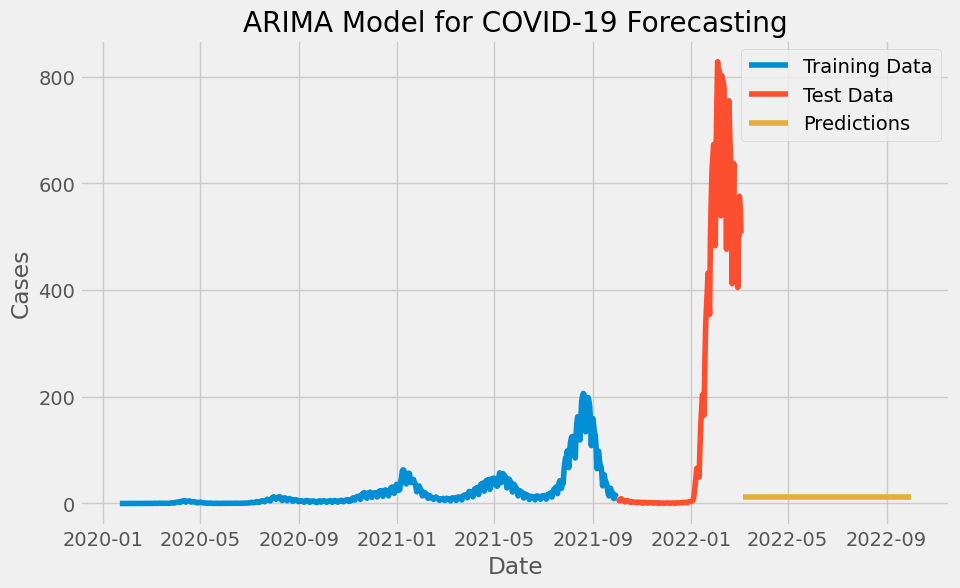

In [192]:
# Plot the actual and predicted values
plt.figure(figsize=(10, 6))
plt.plot(asia_train1.index, asia_train1.values, label='Training Data')
plt.plot(asia_test1.index, asia_test1.values, label='Test Data')
plt.plot(forecast_df_asia1.index, forecast_df_asia1.values, label='Predictions')
plt.legend()
plt.title('ARIMA Model for COVID-19 Forecasting')
plt.xlabel('Date')
plt.ylabel('Cases')
plt.show()

In [193]:
asia_2=create_df(data,'Singapore')

In [194]:
asia_2=asia_2.loc[:,['Date',"new cases per million"]]
asia_2=asia_2.set_index('Date')

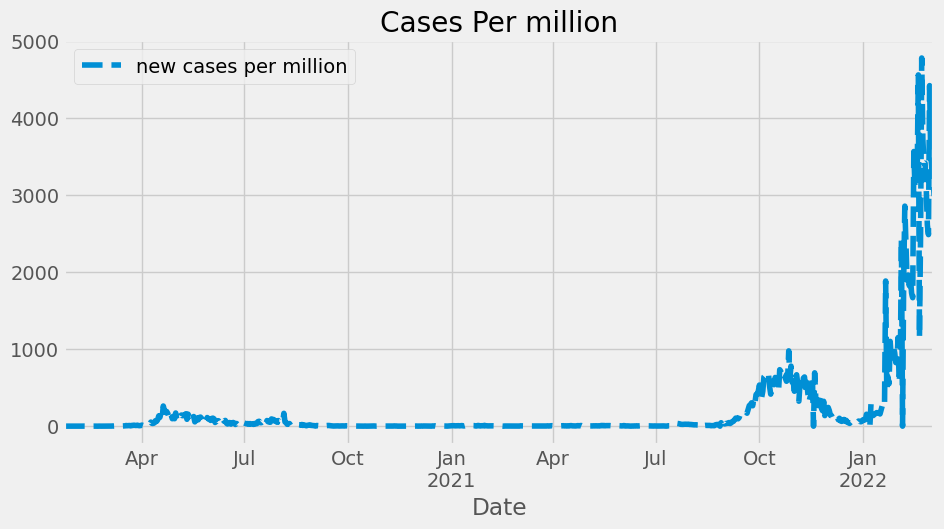

In [195]:
color_pal = sns.color_palette()
asia_2.plot(style='--',
               figsize=(10,5),
               ms=1,
               color=color_pal[0],
               title='Cases Per million')
plt.show()


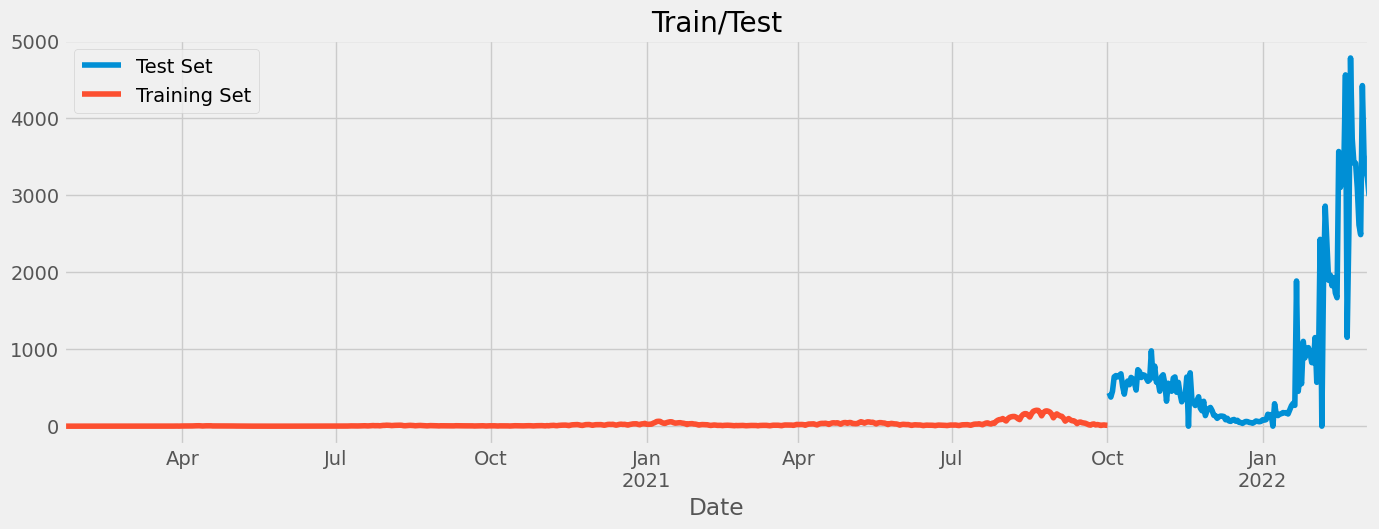

In [196]:
split_date='01-oct-2021'

asia_train2 = asia_2.loc[asia_2.index <=split_date].copy()
asia_test2 = asia_2.loc[asia_2.index >split_date].copy()

asia_test2 \
          .rename(columns={"new cases per million": 'Test Set'}) \
          .join(asia_train1.rename(columns={"new cases per million": 'Training Set'}),
                how='outer') \
          .plot(figsize=(15,5), title='Train/Test')
plt.show()

In [197]:
# fit an ARIMA model and plot residual errors
from pandas import datetime
from pandas import read_csv
from pandas import DataFrame
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima

from matplotlib import pyplot
# load dataset
auto_arima_model=auto_arima(asia_train2,trace=True,Supress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=5092.926, Time=1.00 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=5962.490, Time=0.09 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=5450.947, Time=0.08 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=5307.147, Time=0.32 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=5094.820, Time=0.63 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=5096.980, Time=0.39 sec
 ARIMA(3,2,2)(0,0,0)[0]             : AIC=5091.214, Time=0.85 sec
 ARIMA(3,2,1)(0,0,0)[0]             : AIC=5097.209, Time=0.33 sec
 ARIMA(4,2,2)(0,0,0)[0]             : AIC=5087.757, Time=0.57 sec
 ARIMA(4,2,1)(0,0,0)[0]             : AIC=5094.795, Time=0.42 sec
 ARIMA(5,2,2)(0,0,0)[0]             : AIC=5088.648, Time=1.34 sec
 ARIMA(4,2,3)(0,0,0)[0]             : AIC=5089.303, Time=1.32 sec
 ARIMA(3,2,3)(0,0,0)[0]             : AIC=5088.933, Time=1.16 sec
 ARIMA(5,2,1)(0,0,0)[0]             : AIC=5092.184, Time=0.62 sec
 ARIMA(5,2,3)(0,0,0)[0]          

In [198]:
# Define function to evaluate model performance
def evaluate_model(predictions_asia2, actual_asia2):
    mse_asia2 = mean_squared_error(actual_asia2, predictions_asia2)
    rmse_asia2 = np.sqrt(mse_asia2)
    mape_asia2 = np.mean(np.abs((actual_asia2 - predictions_asia2) / actual_asia2)) * 100
    return mse_asia2, rmse_asia2, mape_asia2

In [199]:
# Define ARIMA model parameters
p_asia2 = 2
d_asia2 = 1
q_asia2 = 2

In [200]:
# Fit the ARIMA model on train data
model_asia2 = ARIMA(asia_train2, order=(p_asia2, d_asia2, q_asia2))
results = model_asia2.fit()

In [201]:
n_days_asia2 = 365

# Use the trained model to make predictions for the next n_days
forecast_asia2 = results.forecast(steps=n_days_asia2)

In [202]:
# Create a date range for the forecasted dates
forecast_dates_asia2 = pd.date_range(start=asia_2.index[-1], periods=n_days_asia2+1)[1:]

# Convert the forecasted values to a pandas DataFrame
forecast_df_asia2 = pd.DataFrame({'Cases': forecast_asia2}, index=forecast_dates_asia2)

test_predictions_asia2 = results.predict(start=asia_test2.index[0], end=asia_test2.index[-1], dynamic=False)

mse_asia2, rmse_asia2, mape_asia2 = evaluate_model(test_predictions_asia2, asia_test2)

In [203]:
# Print model performance metrics
print(f'Mean Squared Error (MSE): {mse_asia2:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse_asia2:.2f}')
#print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')

Mean Squared Error (MSE): 2274779.65
Root Mean Squared Error (RMSE): 1508.24


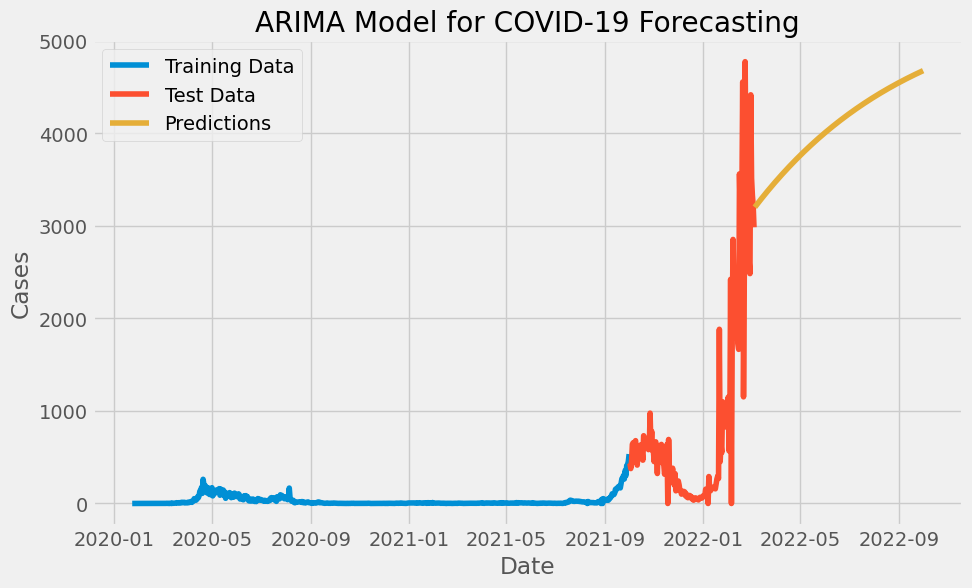

In [204]:
# Plot the actual and predicted values
plt.figure(figsize=(10, 6))
plt.plot(asia_train2.index, asia_train2.values, label='Training Data')
plt.plot(asia_test2.index, asia_test2.values, label='Test Data')
plt.plot(forecast_df_asia2.index, forecast_df_asia2.values, label='Predictions')
plt.legend()
plt.title('ARIMA Model for COVID-19 Forecasting')
plt.xlabel('Date')
plt.ylabel('Cases')
plt.show()

In [205]:
africa_1=create_df(data,'Zimbabwe')

In [206]:
africa_1=africa_1.loc[:,['Date',"new cases per million"]]
africa_1=africa_1.set_index('Date')

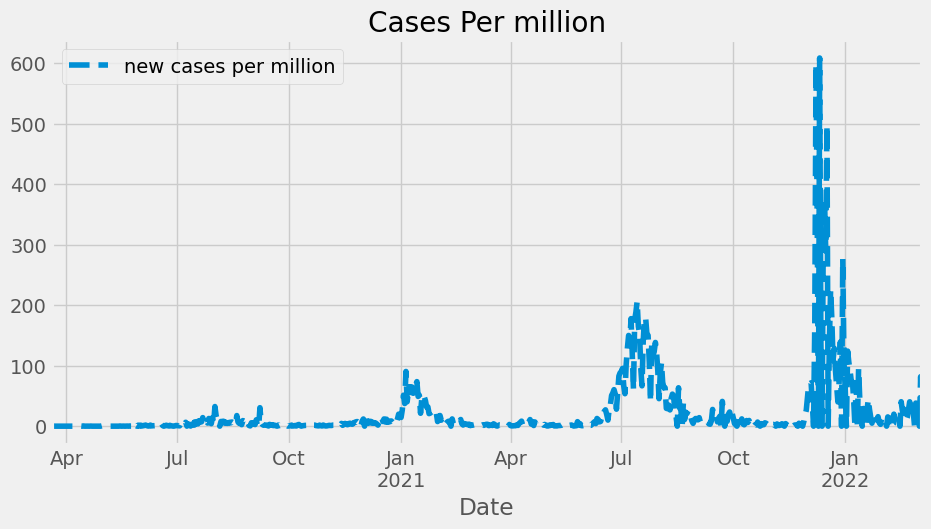

In [207]:
color_pal = sns.color_palette()
africa_1.plot(style='--',
               figsize=(10,5),
               ms=1,
               color=color_pal[0],
               title='Cases Per million')
plt.show()



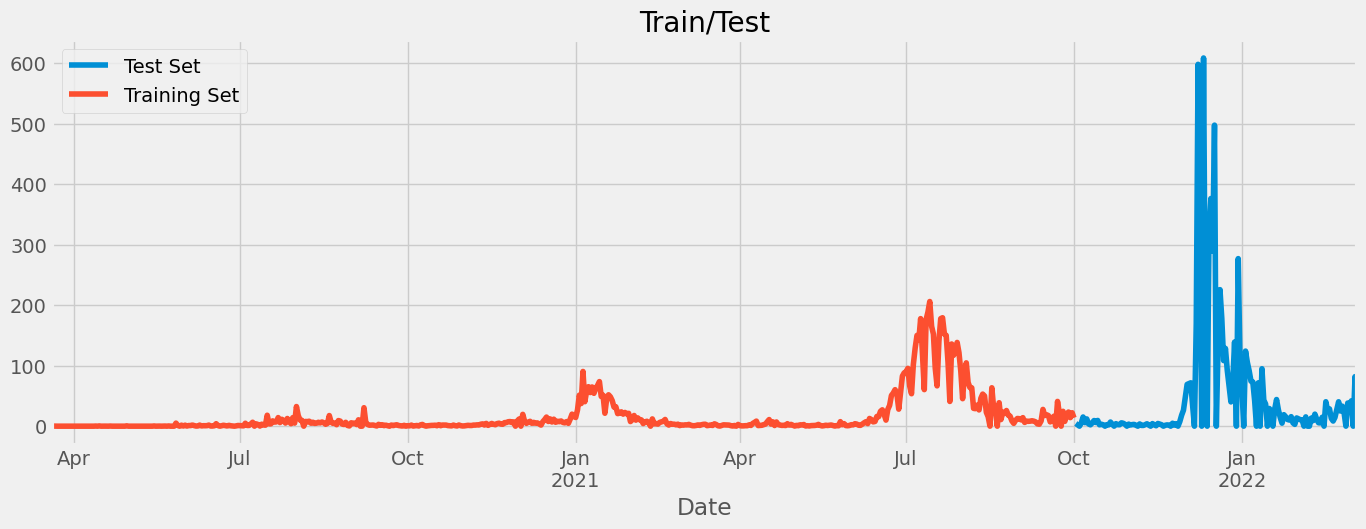

In [208]:
split_date='01-oct-2021'

africa_train1 = africa_1.loc[africa_1.index <=split_date].copy()
africa_test1 = africa_1.loc[africa_1.index >split_date].copy()

africa_test1 \
          .rename(columns={"new cases per million": 'Test Set'}) \
          .join(africa_train1.rename(columns={"new cases per million": 'Training Set'}),
                how='outer') \
          .plot(figsize=(15,5), title='Train/Test')
plt.show()


In [209]:
# fit an ARIMA model and plot residual errors
from pandas import datetime
from pandas import read_csv
from pandas import DataFrame
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima

from matplotlib import pyplot
# load dataset
auto_arima_model=auto_arima(africa_train1,trace=True,Supress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=4305.936, Time=2.28 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=4485.600, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=4463.326, Time=0.16 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=4442.329, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=4483.602, Time=0.07 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=4406.987, Time=1.17 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=4403.777, Time=0.68 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=4279.413, Time=0.99 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=4393.848, Time=0.57 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=4258.366, Time=1.60 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=4368.812, Time=0.62 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=4251.001, Time=2.24 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=4338.773, Time=0.68 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=4251.776, Time=2.31 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept

In [210]:
# Define function to evaluate model performance
def evaluate_model(predictions_africa1, actual_africa1):
    mse_africa1 = mean_squared_error(actual_africa1, predictions_africa1)
    rmse_africa1 = np.sqrt(mse_africa1)
    mape_africa1 = np.mean(np.abs((actual_africa1 - predictions_africa1) / actual_africa1)) * 100
    return mse_africa1, rmse_africa1, mape_africa1


In [211]:
# Define ARIMA model parameters
p_africa1 = 2
d_africa1 = 1
q_africa1 = 2

# Fit the ARIMA model on train data
model_africa1 = ARIMA(africa_train1, order=(p_africa1, d_africa1, q_africa1))
results = model_africa1.fit()


In [212]:
n_days_africa1 = 365

# Use the trained model to make predictions for the next n_days
forecast_africa1 = results.forecast(steps=n_days_africa1)

In [213]:

# Create a date range for the forecasted dates
forecast_dates_africa1 = pd.date_range(start=africa_1.index[-1], periods=n_days_africa1+1)[1:]

In [214]:
# Convert the forecasted values to a pandas DataFrame
forecast_df_africa1 = pd.DataFrame({'Cases': forecast_africa1}, index=forecast_dates_africa1)

test_predictions_africa1 = results.predict(start=africa_test1.index[0], end=africa_test1.index[-1], dynamic=False)

mse_africa1, rmse_africa1, mape_africa1 = evaluate_model(test_predictions_africa1, africa_test1)

In [215]:
# Print model performance metrics
print(f'Mean Squared Error (MSE): {mse_africa1:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse_africa1:.2f}')
#print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')

Mean Squared Error (MSE): 10553.60
Root Mean Squared Error (RMSE): 102.73


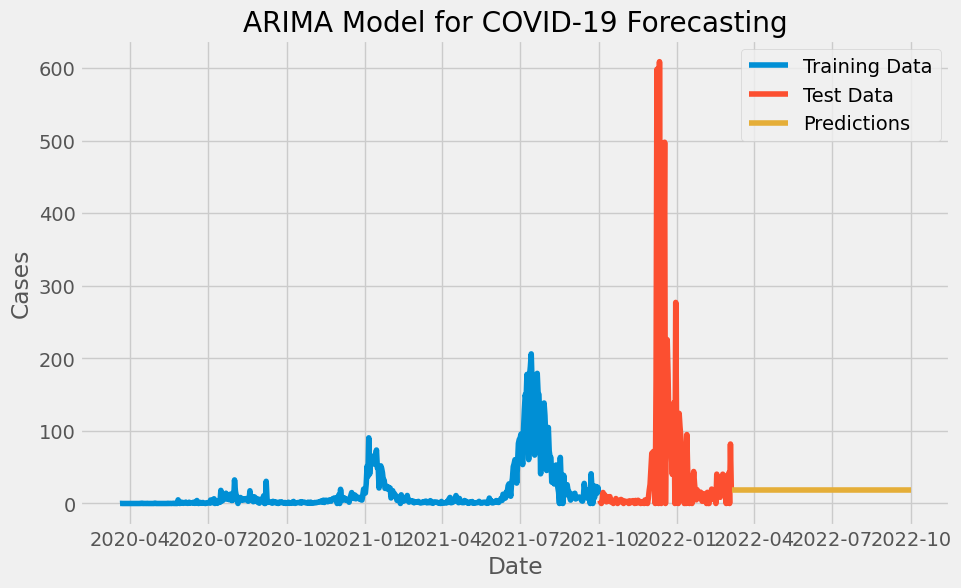

In [216]:
# Plot the actual and predicted values
plt.figure(figsize=(10, 6))
plt.plot(africa_train1.index, africa_train1.values, label='Training Data')
plt.plot(africa_test1.index, africa_test1.values, label='Test Data')
plt.plot(forecast_df_africa1.index, forecast_df_africa1.values, label='Predictions')
plt.legend()
plt.title('ARIMA Model for COVID-19 Forecasting')
plt.xlabel('Date')
plt.ylabel('Cases')
plt.show()

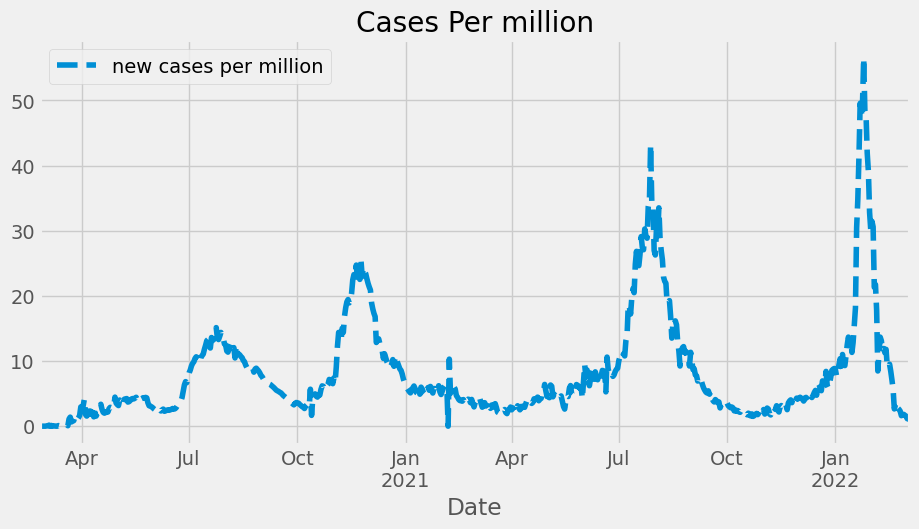

In [217]:
africa_2=create_df(data,'Algeria')

africa_2=africa_2.loc[:,['Date',"new cases per million"]]
africa_2=africa_2.set_index('Date')

color_pal = sns.color_palette()
africa_2.plot(style='--',
               figsize=(10,5),
               ms=1,
               color=color_pal[0],
               title='Cases Per million')
plt.show()

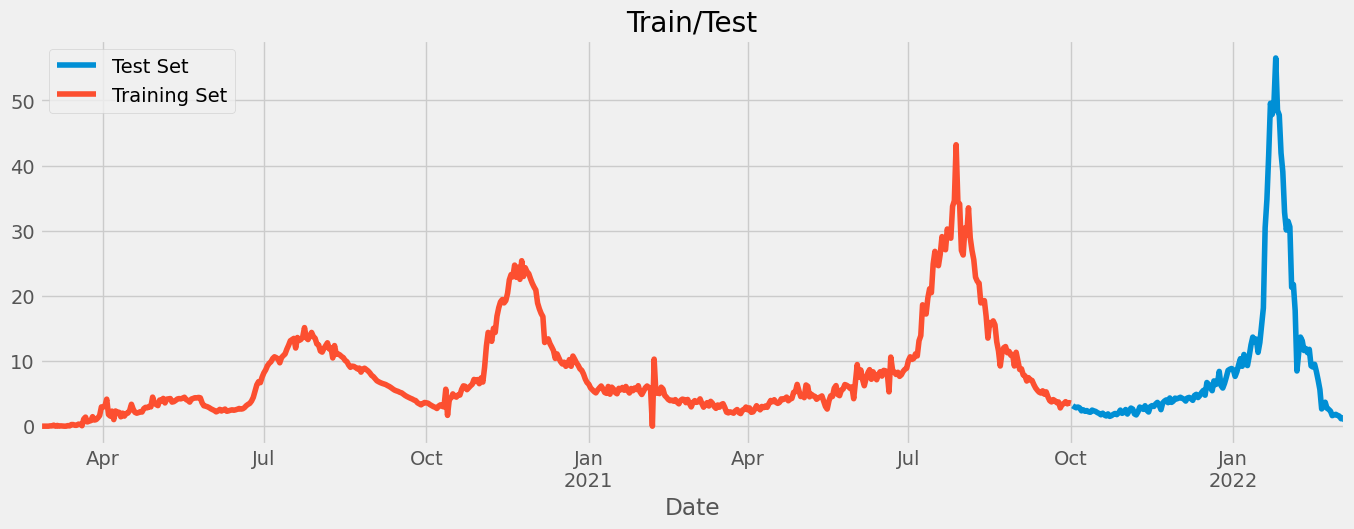

In [218]:
split_date='01-oct-2021'

africa_train2 = africa_2.loc[africa_2.index <=split_date].copy()
africa_test2 = africa_2.loc[africa_2.index >split_date].copy()

africa_test2 \
          .rename(columns={"new cases per million": 'Test Set'}) \
          .join(africa_train2.rename(columns={"new cases per million": 'Training Set'}),
                how='outer') \
          .plot(figsize=(15,5), title='Train/Test')
plt.show()

In [219]:
# fit an ARIMA model and plot residual errors
from pandas import datetime
from pandas import read_csv
from pandas import DataFrame
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima

from matplotlib import pyplot
# load dataset
auto_arima_model=auto_arima(africa_train2,trace=True,Supress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=1891.383, Time=0.98 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1939.511, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1895.365, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=1904.381, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1937.524, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=1893.661, Time=0.33 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=1894.008, Time=0.32 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=1890.447, Time=2.57 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=1895.896, Time=0.91 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=1867.592, Time=2.96 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=1894.573, Time=0.57 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=1835.535, Time=2.44 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=1862.346, Time=1.19 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=1837.820, Time=2.62 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept

In [220]:
# Define function to evaluate model performance
def evaluate_model(predictions_africa2, actual_africa2):
    mse_africa2 = mean_squared_error(actual_africa2, predictions_africa2)
    rmse_africa2 = np.sqrt(mse_africa2)
    mape_africa2 = np.mean(np.abs((actual_africa2 - predictions_africa2) / actual_africa2)) * 100
    return mse_africa2, rmse_africa2, mape_africa2

In [221]:
# Define ARIMA model parameters
p_africa2 = 2
d_africa2 = 1
q_africa2 = 2

# Fit the ARIMA model on train data
model_africa2 = ARIMA(africa_train2, order=(p_africa2, d_africa2, q_africa2))
results = model_africa2.fit()


In [222]:
n_days_africa2 = 365

# Use the trained model to make predictions for the next n_days
forecast_africa2 = results.forecast(steps=n_days_africa2)


# Create a date range for the forecasted dates
forecast_dates_africa2 = pd.date_range(start=africa_2.index[-1], periods=n_days_africa2+1)[1:]

# Convert the forecasted values to a pandas DataFrame
forecast_df_africa2 = pd.DataFrame({'Cases': forecast_africa2}, index=forecast_dates_africa2)

test_predictions_africa2 = results.predict(start=africa_test2.index[0], end=africa_test2.index[-1], dynamic=False)

mse_africa2, rmse_africa2, mape_africa2 = evaluate_model(test_predictions_africa2, africa_test2)


In [223]:
# Print model performance metrics
print(f'Mean Squared Error (MSE): {mse_africa2:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse_africa2:.2f}')
#print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')

Mean Squared Error (MSE): 161.39
Root Mean Squared Error (RMSE): 12.70


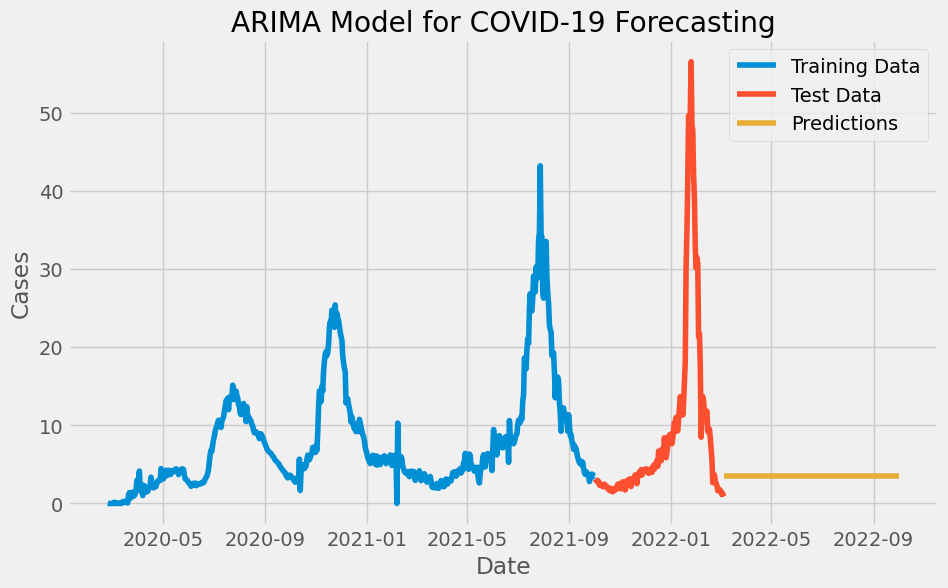

In [224]:
# Plot the actual and predicted values
plt.figure(figsize=(10, 6))
plt.plot(africa_train2.index, africa_train2.values, label='Training Data')
plt.plot(africa_test2.index, africa_test2.values, label='Test Data')
plt.plot(forecast_df_africa2.index, forecast_df_africa2.values, label='Predictions')
plt.legend()
plt.title('ARIMA Model for COVID-19 Forecasting')
plt.xlabel('Date')
plt.ylabel('Cases')
plt.show()

In [225]:
#NorthAmerica

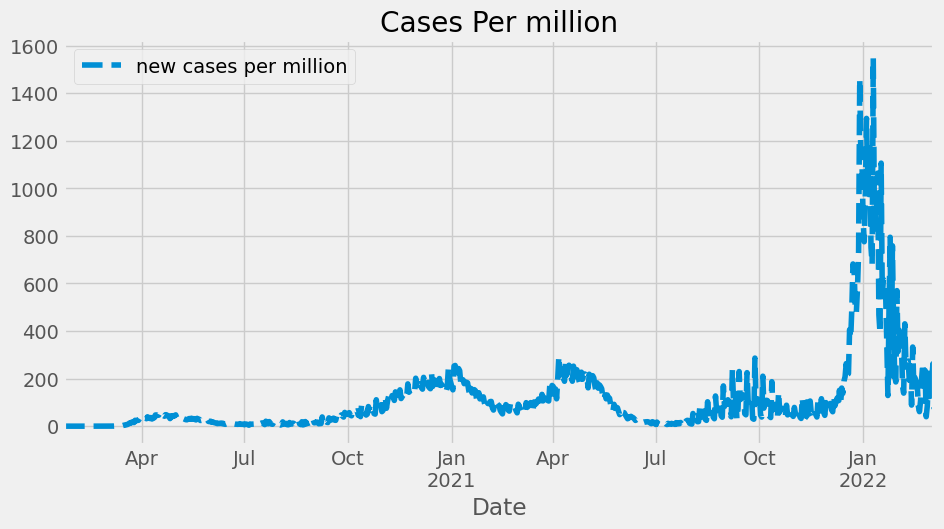

In [226]:
northamerica_1=create_df(data,'Canada')

northamerica_1=northamerica_1.loc[:,['Date',"new cases per million"]]
northamerica_1=northamerica_1.set_index('Date')

color_pal = sns.color_palette()
northamerica_1.plot(style='--',
               figsize=(10,5),
               ms=1,
               color=color_pal[0],
               title='Cases Per million')
plt.show()

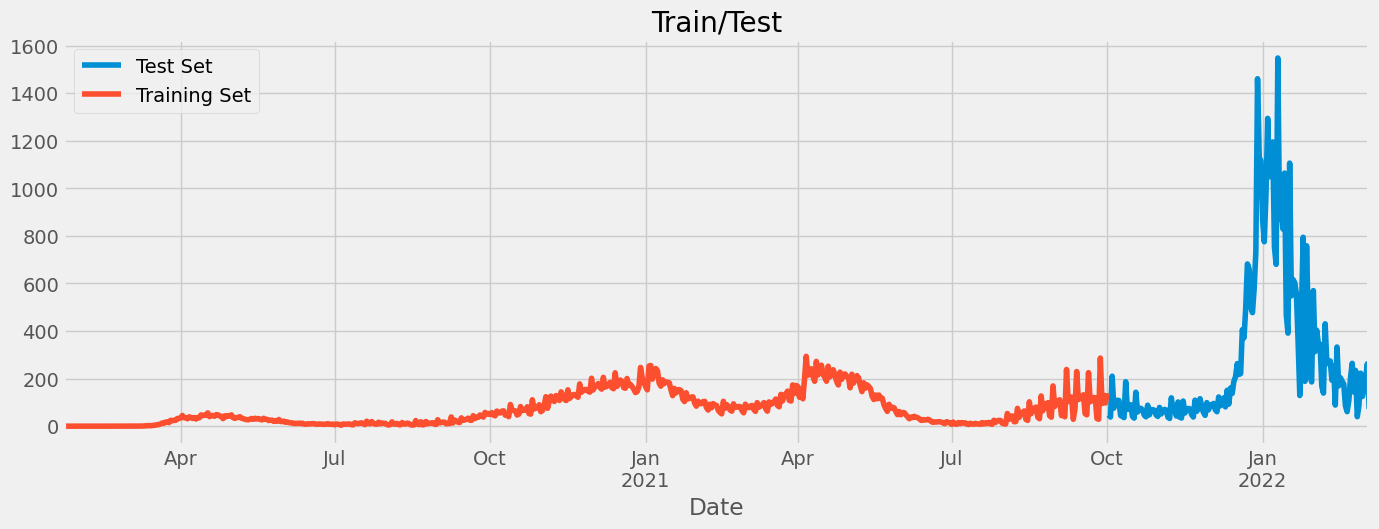

In [227]:
split_date='01-oct-2021'

northamerica_train1 = northamerica_1.loc[northamerica_1.index <=split_date].copy()
northamerica_test1 = northamerica_1.loc[northamerica_1.index >split_date].copy()

northamerica_test1 \
          .rename(columns={"new cases per million": 'Test Set'}) \
          .join(northamerica_train1.rename(columns={"new cases per million": 'Training Set'}),
                how='outer') \
          .plot(figsize=(15,5), title='Train/Test')
plt.show()

In [228]:
# fit an ARIMA model and plot residual errors
from pandas import datetime
from pandas import read_csv
from pandas import DataFrame
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima

from matplotlib import pyplot
# load dataset
auto_arima_model=auto_arima(northamerica_train1,trace=True,Supress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5573.415, Time=1.63 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5933.648, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5808.334, Time=0.12 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5657.359, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5931.684, Time=0.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=5656.493, Time=0.66 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5637.752, Time=0.48 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=5641.364, Time=1.05 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=3.53 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5658.103, Time=0.74 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=5579.968, Time=0.80 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=5639.289, Time=0.56 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=2.12 sec
 ARIMA(2,1,2)(0,0,0)[0]             : AIC=5571.810, Time=0.62 sec
 ARIMA(1,1,2)(0,0,0)[0]             : AIC=5

In [229]:
# Define function to evaluate model performance
def evaluate_model(predictions_northamerica1, actual_northamerica1):
    mse_northamerica1 = mean_squared_error(actual_northamerica1, predictions_northamerica1)
    rmse_northamerica1 = np.sqrt(mse_northamerica1)
    mape_northamerica1 = np.mean(np.abs((actual_northamerica1 - predictions_northamerica1) / actual_northamerica1)) * 100
    return mse_northamerica1, rmse_northamerica1, mape_northamerica1

In [230]:
# Define ARIMA model parameters
p_northamerica1 = 2
d_northamerica1 = 1
q_northamerica1 = 2

# Fit the ARIMA model on train data
model_northamerica1 = ARIMA(northamerica_train1, order=(p_northamerica1, d_northamerica1, q_northamerica1))
results = model_northamerica1.fit()

In [231]:
n_days_northamerica1 = 365

# Use the trained model to make predictions for the next n_days
forecast_northamerica1 = results.forecast(steps=n_days_northamerica1)


# Create a date range for the forecasted dates
forecast_dates_northamerica1 = pd.date_range(start=northamerica_1.index[-1], periods=n_days_northamerica1+1)[1:]

# Convert the forecasted values to a pandas DataFrame
forecast_df_northamerica1 = pd.DataFrame({'Cases': forecast_northamerica1}, index=forecast_dates_northamerica1)

test_predictions_northamerica1 = results.predict(start=northamerica_test1.index[0], end=northamerica_test1.index[-1], dynamic=False)

mse_northamerica1, rmse_northamerica1, mape_northamerica1 = evaluate_model(test_predictions_northamerica1, northamerica_test1)


In [232]:
# Print model performance metrics
print(f'Mean Squared Error (MSE): {mse_northamerica1:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse_northamerica1:.2f}')
#print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')

Mean Squared Error (MSE): 131000.68
Root Mean Squared Error (RMSE): 361.94


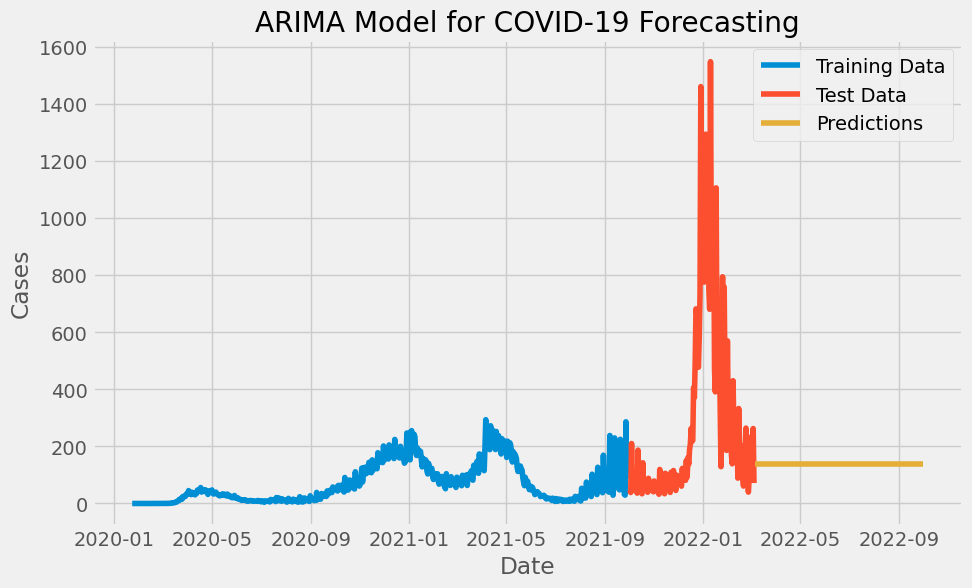

In [233]:
# Plot the actual and predicted values
plt.figure(figsize=(10, 6))
plt.plot(northamerica_train1.index, northamerica_train1.values, label='Training Data')
plt.plot(northamerica_test1.index, northamerica_test1.values, label='Test Data')
plt.plot(forecast_df_northamerica1.index, forecast_df_northamerica1.values, label='Predictions')
plt.legend()
plt.title('ARIMA Model for COVID-19 Forecasting')
plt.xlabel('Date')
plt.ylabel('Cases')
plt.show()

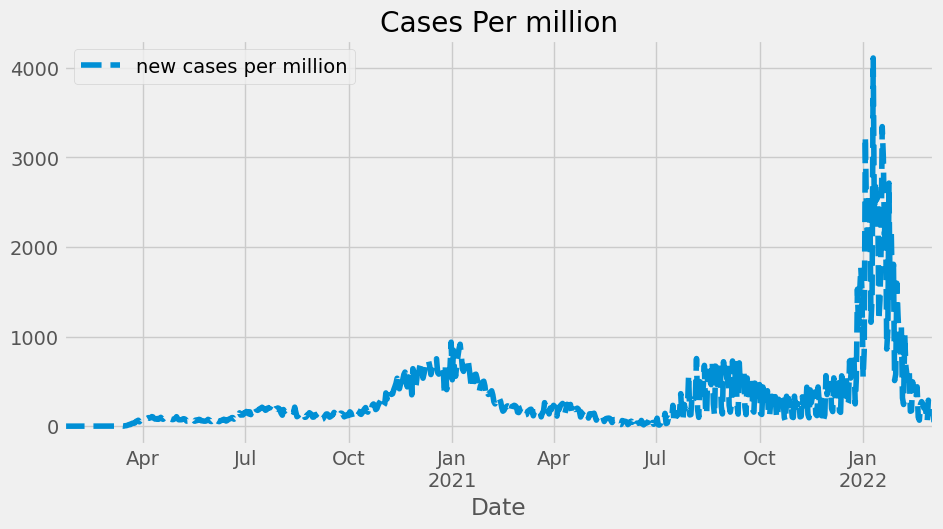

In [234]:
northamerica_2=create_df(data,"United States")

northamerica_2=northamerica_2.loc[:,['Date',"new cases per million"]]
northamerica_2=northamerica_2.set_index('Date')

color_pal = sns.color_palette()
northamerica_2.plot(style='--',
               figsize=(10,5),
               ms=1,
               color=color_pal[0],
               title='Cases Per million')
plt.show()

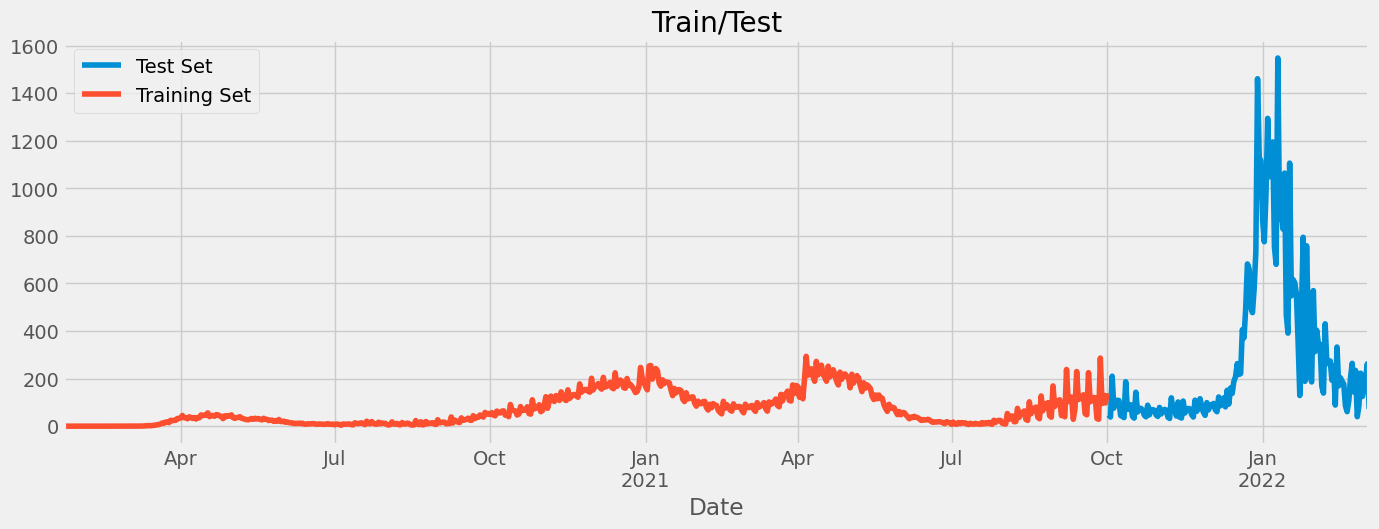

In [235]:
split_date='01-oct-2021'

northamerica_train2 = northamerica_2.loc[northamerica_2.index <=split_date].copy()
northamerica_test2 = northamerica_2.loc[northamerica_2.index >split_date].copy()

northamerica_test1 \
          .rename(columns={"new cases per million": 'Test Set'}) \
          .join(northamerica_train1.rename(columns={"new cases per million": 'Training Set'}),
                how='outer') \
          .plot(figsize=(15,5), title='Train/Test')
plt.show()

In [236]:
# fit an ARIMA model and plot residual errors
from pandas import datetime
from pandas import read_csv
from pandas import DataFrame
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima

from matplotlib import pyplot
# load dataset
auto_arima_model=auto_arima(northamerica_train2,trace=True,Supress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=7131.896, Time=2.65 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=7484.853, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=7392.001, Time=0.21 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=7218.514, Time=0.65 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=7482.886, Time=0.08 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=7200.784, Time=1.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=7198.372, Time=0.64 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=7194.499, Time=1.55 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=7072.613, Time=1.61 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=7141.365, Time=1.10 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=7064.597, Time=1.80 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=6999.029, Time=2.18 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=2.82 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=6866.043, Time=3.68 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : 

In [237]:
# Define function to evaluate model performance
def evaluate_model(predictions_northamerica2, actual_northamerica2):
    mse_northamerica2 = mean_squared_error(actual_northamerica2, predictions_northamerica2)
    rmse_northamerica2 = np.sqrt(mse_northamerica1)
    mape_northamerica2 = np.mean(np.abs((actual_northamerica2 - predictions_northamerica2) / actual_northamerica2)) * 100
    return mse_northamerica2, rmse_northamerica2, mape_northamerica2

In [238]:
# Define ARIMA model parameters
p_northamerica2 = 2
d_northamerica2 = 1
q_northamerica2 = 2

# Fit the ARIMA model on train data
model_northamerica2 = ARIMA(northamerica_train2, order=(p_northamerica2, d_northamerica2, q_northamerica2))
results = model_northamerica2.fit()

In [239]:
n_days_northamerica2 = 365

# Use the trained model to make predictions for the next n_days
forecast_northamerica2 = results.forecast(steps=n_days_northamerica2)


# Create a date range for the forecasted dates
forecast_dates_northamerica2 = pd.date_range(start=northamerica_2.index[-1], periods=n_days_northamerica2+1)[1:]

# Convert the forecasted values to a pandas DataFrame
forecast_df_northamerica2 = pd.DataFrame({'Cases': forecast_northamerica2}, index=forecast_dates_northamerica2)

test_predictions_northamerica2 = results.predict(start=northamerica_test2.index[0], end=northamerica_test2.index[-1], dynamic=False)

mse_northamerica2, rmse_northamerica2, mape_northamerica2 = evaluate_model(test_predictions_northamerica2, northamerica_test2)


In [240]:

# Print model performance metrics
print(f'Mean Squared Error (MSE): {mse_northamerica2:.2f}')
print(f'Root Mean Squared Error (RMSE): {rmse_northamerica2:.2f}')
#print(f'Mean Absolute Percentage Error (MAPE): {mape:.2f}%')

Mean Squared Error (MSE): 726595.05
Root Mean Squared Error (RMSE): 361.94


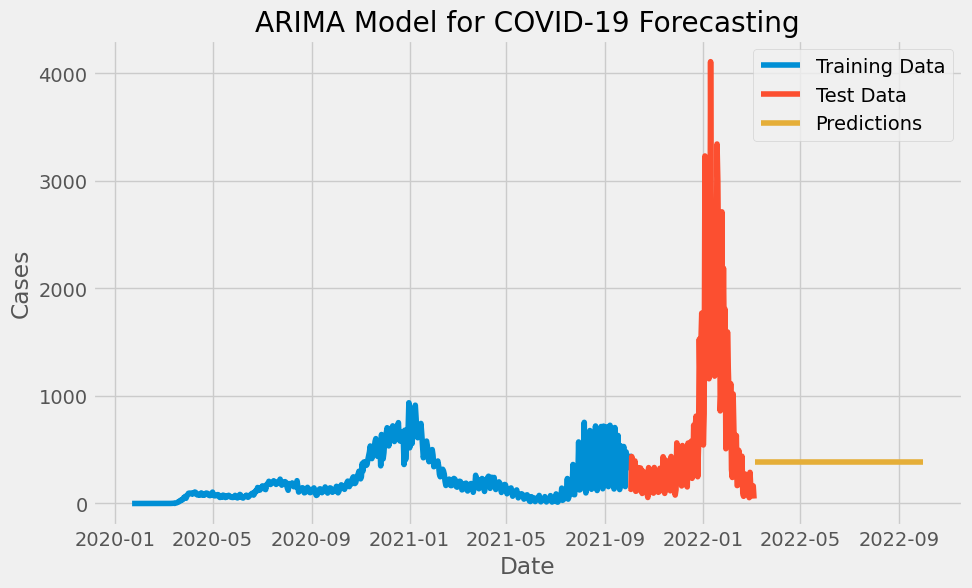

In [241]:
# Plot the actual and predicted values
plt.figure(figsize=(10, 6))
plt.plot(northamerica_train2.index, northamerica_train2.values, label='Training Data')
plt.plot(northamerica_test2.index, northamerica_test2.values, label='Test Data')
plt.plot(forecast_df_northamerica2.index, forecast_df_northamerica2.values, label='Predictions')
plt.legend()
plt.title('ARIMA Model for COVID-19 Forecasting')
plt.xlabel('Date')
plt.ylabel('Cases')
plt.show()

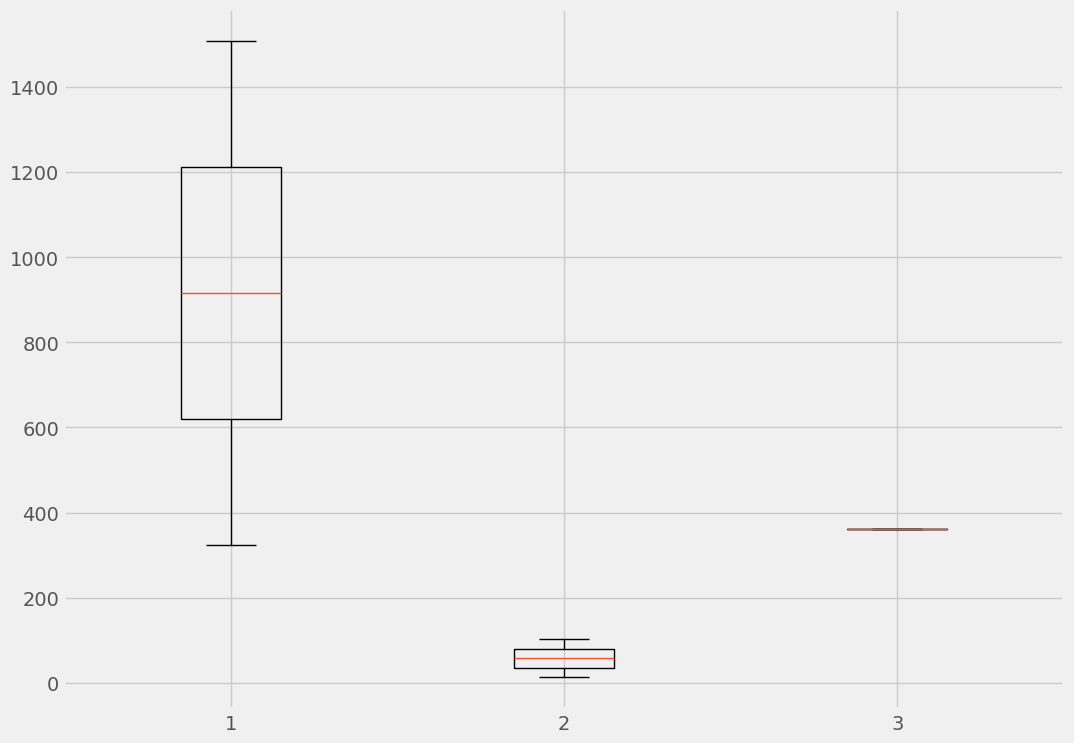

In [242]:
#RMSE

rmse_asia=(rmse_asia1,rmse_asia2)
rmse_africa=(rmse_africa1,rmse_africa2)
rmse_northamerica=(rmse_northamerica1,rmse_northamerica2)

rmse_all=[rmse_asia,rmse_africa,rmse_northamerica]


fig = plt.figure(figsize =(10, 7))
 
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
 
# Creating plot
bp = ax.boxplot(rmse_all)
 
# show plot
plt.show()

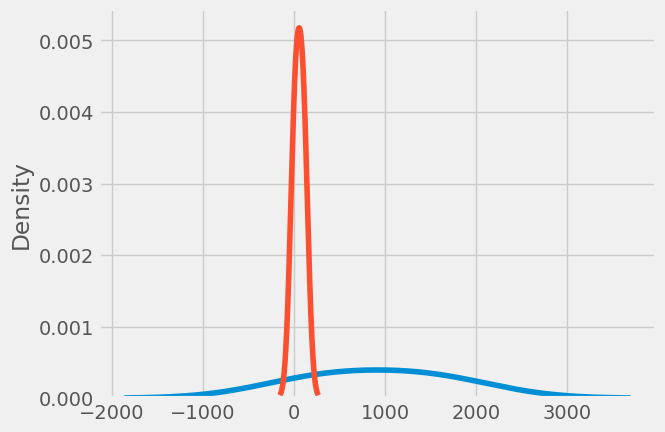

In [243]:
# Create a density distribution

sns.kdeplot(rmse_asia, label='RMSE 1')
sns.kdeplot(rmse_africa, label='RMSE 2')
sns.kdeplot(rmse_northamerica, label='RMSE 3')

# Show the plot
import matplotlib.pyplot as plt
plt.show()